https://chatgpt.com/share/686b3972-86d4-8003-add0-04d64f3d5b83

https://www.perplexity.ai/search/import-numpy-as-np-from-tqdm-i-vBk7y499QCeeOL3tTgl4AA

In [1]:
#IMP Concept

# #Build the tf.data.Dataset   ,see pipeline belwo and explaination

# import tensorflow as tf

# # Generator yields one triplet of embeddings at a time
# def triplet_generator():
#     for a, p, n in zip(anchors, positives, negatives):
#         yield a, p, n

# #  What it is: A little Python function that, each time you ask it, gives you the next (anchor, positive, negative) triple of embeddings.
# # Why: It’s a convenient way to stream your precomputed 128‑dim vectors one triplet at a time, without loading them all at once somewhere else.       

# # Create Dataset with correct output types/shapes
# ds = tf.data.Dataset.from_generator(
#     triplet_generator,
#     output_signature=(
#         tf.TensorSpec((128,), tf.float32),   # Only when you call .batch(32) does TensorFlow accumulate 32 individual triplet elements into one batch.
#         tf.TensorSpec((128,), tf.float32),
#         tf.TensorSpec((128,), tf.float32),
#     )
# )



# # What it does:
# # Wraps your triplet_generator() in a TensorFlow object called a Dataset.
# # Tells TensorFlow, “Each item I yield is three float32 vectors of length 128.”
# # Why:
# # This turns your plain‑Python generator into something TensorFlow can optimize and plug directly into model.fit().
# # You get back a “stream” of (anchor, positive, negative) triplets as tf.Tensor objects, not NumPy arrays or Python lists.


# #in other dataset(Static) (Python list / NumPy array / Pandas DataFrame) we first load whole data then fn , in case of large data RAM full

# #in tf.data.Dataset(Streaming)     A tf.data.Dataset is TensorFlow’s way of representing and managing your data as a pipeline   A tf.data.Dataset is TensorFlow’s way of representing and managing your data as a pipeline of transformations and batches,(we creatae a pipeline , tell how to read the data we have ,  You define how to read, preprocess, and batch data.)  Data is fetched “just in time” in small pieces (streams) during training. ,  You never need to load the entire dataset into RAM.


# # Shuffle, batch, and prefetch for performance
# BATCH_SIZE = 32
# ds = (
#     ds
#     .shuffle(buffer_size=len(anchors))
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )


# # What it does:


# # .shuffle(buffer_size=len(anchors)):->
# # Keeps a “buffer” of that many triplets and randomly picks the next one from within the buffer.
# # Why:
# # Prevents the model from seeing the same sequence of triplets every epoch, which helps it generalize better.



# # .batch(BATCH_SIZE):->
# # Rather than returning one triplet at a time, it groups BATCH_SIZE triplets into a single “batch.”
# # So instead of (anchor, pos, neg) shapes (128,), you now get three tensors of shape (BATCH_SIZE, 128).




# # .prefetch(tf.data.AUTOTUNE):->
# # While your model is busy training on one batch, TensorFlow prepares (loads, shuffles, batches) the next batch in the background.


# # Composable Transformations
# # With a Dataset you can chain simple operations:

# # python
# # Copy
# # Edit
# # ds = tf.data.Dataset.from_generator(...)
# #    .shuffle(buffer_size=1000)
# #    .map(preprocess_fn, num_parallel_calls=4)
# #    .batch(32)
# #    .prefetch(1)
# # Each of these methods returns a new Dataset:

# # shuffle: randomly reorders elements
# # map: applies a function (e.g. image decoding, augmentation)
# # batch: groups elements into fixed‑size batches
# # prefetch: overlaps data preparation with model execution






In [2]:
import os

# ✅ Enables CPU-optimized oneDNN ops (speeds up training)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# ✅ Optional: Set visible threads (for reproducibility or performance tuning)
os.environ['OMP_NUM_THREADS'] = '8'   # same as number of cores
os.environ['KMP_BLOCKTIME'] = '0'



In [3]:
print("TF_ENABLE_ONEDNN_OPTS:", os.environ.get('TF_ENABLE_ONEDNN_OPTS'))
print("OMP_NUM_THREADS:", os.environ.get('OMP_NUM_THREADS'))
print("KMP_BLOCKTIME:", os.environ.get('KMP_BLOCKTIME'))


TF_ENABLE_ONEDNN_OPTS: 1
OMP_NUM_THREADS: 8
KMP_BLOCKTIME: 0


In [4]:
import tensorflow as tf

# ✅ Set CPU parallelism (you have 8 cores → use 8 intra, 2 inter threads)
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(2)

print("Threading set: Intra=8, Inter=2")


Threading set: Intra=8, Inter=2


In [5]:
import pandas as pd
import tensorflow as tf
from collections import defaultdict
import random
import nltk
from nltk import word_tokenize, pos_tag


In [6]:
def load_captions(path="flickr8k/captions.txt"):  
    df = pd.read_csv(path)  
    return df.groupby("image")["caption"].apply(list).to_dict()

In [7]:
def extract_keywords(image_captions):  
    image_keywords = defaultdict(set)  
    for img, caps in image_captions.items():  
        for c in caps:  
            for w, tag in pos_tag(word_tokenize(c.lower())):  
                if tag.startswith('NN'):  
                    image_keywords[img].add(w)
    return image_keywords

In [8]:
def generate_triplets(image_keywords):  
    triplets = []  
    images = list(image_keywords.keys())  
    for anchor in images:  
        kws = image_keywords[anchor]  
        positives = [i for i in images if i != anchor and image_keywords[i] & kws]  
        negatives = [i for i in images if i != anchor and not (image_keywords[i] & kws)]  
        if positives and negatives:  
            p = random.choice(positives)  
            n = random.choice(negatives)  
            triplets.append((anchor, p, n))  
    return triplets

In [9]:
def build_triplet_dataset(triplets, image_captions, img_size=(224,224), batch_size=16):  
    def gen():  
        for a,p,n in triplets:  
            yield (  
                f"flickr8k/images/{a}", image_captions[a][0],  
                f"flickr8k/images/{p}", image_captions[p][0],  
                f"flickr8k/images/{n}", image_captions[n][0],  
            )  

    #..................
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((), tf.string), tf.TensorSpec((), tf.string),
            tf.TensorSpec((), tf.string), tf.TensorSpec((), tf.string),
            tf.TensorSpec((), tf.string), tf.TensorSpec((), tf.string),
        )
    )
    def parse(a_path, a_txt, p_path, p_txt, n_path, n_txt):  
        def load_img(path):  
            img = tf.io.read_file(path)  
            img = tf.image.decode_jpeg(img, channels=3)  
            img = tf.image.resize(img, img_size)/255.0  
            return img  
        return (
            load_img(a_path), a_txt,
            load_img(p_path), p_txt,
            load_img(n_path), n_txt,
        )
    return (
        ds
        .map(parse, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
#..................

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model, Input

In [11]:
def build_image_branch():
    img_in = Input(shape=(224,224,3), name="image_input")
    base = tf.keras.applications.ResNet50(include_top=False, pooling="avg", weights="imagenet")
    base.trainable = False
    x = base(img_in)
    x = layers.Dense(256, activation="relu")(x)
    return Model(img_in, x, name="ImageBranch")


In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model, Input

# 1. Define your serializable USE wrapper here
@tf.keras.utils.register_keras_serializable()
class UniversalEmbeddingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    def call(self, x):
        x = tf.squeeze(tf.cast(x, tf.string))
        return self.use(x)

# 2. Now define your text branch using that layer
def build_text_branch():
    inp = Input(shape=(1,), dtype=tf.string, name="text_input")
    x   = UniversalEmbeddingLayer()(inp)
    x   = layers.Dense(256, activation="relu", name="text_proj")(x)
    return Model(inputs=inp, outputs=x, name="TextBranch")

# 3. Continue with image branch, fusion model, training loop, etc.


In [13]:
def build_fusion_model(embed_dim=128):
    img_in = Input(shape=(256,), name="image_features")
    txt_in = Input(shape=(256,), name="text_features")
    merged = layers.Concatenate()([img_in, txt_in])
    x = layers.Dense(embed_dim, name="fusion_dense")(merged)
    x = layers.Lambda(
        lambda y: tf.math.l2_normalize(y, axis=1),
        output_shape=lambda s: s
    )(x)
    return Model(inputs=[img_in, txt_in], outputs=x, name="FusionModel")


In [14]:
def embed_text(caption_list):
    return use(caption_list).numpy()  # Shape: (batch_size, 512)


In [15]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Input, Model

import tensorflow_hub as hub
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


import numpy as np

def load_data_with_text_features(triplets, image_captions, batch_size=16):
    for a, p, n in triplets:
        yield (
            f"flickr8k/images/{a}", use([image_captions[a][0]]).numpy()[0],
            f"flickr8k/images/{p}", use([image_captions[p][0]]).numpy()[0],
            f"flickr8k/images/{n}", use([image_captions[n][0]]).numpy()[0],
        )


In [16]:
image_captions = load_captions()
image_keywords = extract_keywords(image_captions)
triplets = generate_triplets(image_keywords)
ds = build_triplet_dataset(triplets, image_captions, batch_size=16)

In [17]:
import sys, os
sys.path.append(os.getcwd())

In [18]:
image_model = build_image_branch()
text_model = build_text_branch()
fusion_model = build_fusion_model()

In [19]:
def triplet_loss(a, p, n, margin=0.3):
    dp = tf.reduce_sum(tf.square(a-p), axis=1)
    dn = tf.reduce_sum(tf.square(a-n), axis=1)
    return tf.reduce_mean(tf.maximum(dp - dn + margin, 0.0))

optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
import numpy as np
from tqdm import tqdm

# 1. Compute how many batches make up one epoch
total_samples   = len(triplets)
batch_size      = 32
steps_per_epoch = (total_samples + batch_size - 1) // batch_size  # ceiling division

# 2. Early‑stopping parameters
EPOCHS    = 5
PATIENCE  = 2
best_loss = np.inf
no_improve = 0

for epoch in range(EPOCHS):
    total_loss = 0.0
    batch_count = 0

    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")
    for batch_index, (a_img, a_txt, p_img, p_txt, n_img, n_txt) in tqdm(enumerate(ds), total=steps_per_epoch, desc=f"Epoch {epoch+1}", leave=False):
        if batch_index >= steps_per_epoch:
            break

        with tf.GradientTape() as tape:
            ai = image_model(a_img, training=True)
            at = text_model(a_txt, training=True)
            af = fusion_model([ai, at], training=True)

            pi = image_model(p_img, training=True)
            pt = text_model(p_txt, training=True)
            pf = fusion_model([pi, pt], training=True)

            ni = image_model(n_img, training=True)
            nt = text_model(n_txt, training=True)
            nf = fusion_model([ni, nt], training=True)

            loss = triplet_loss(af, pf, nf)

        grads = tape.gradient(
            loss,
            image_model.trainable_weights +
            text_model.trainable_weights +
            fusion_model.trainable_weights
        )
        optimizer.apply_gradients(zip(
            grads,
            image_model.trainable_weights +
            text_model.trainable_weights +
            fusion_model.trainable_weights
        ))

        total_loss += loss.numpy()

        # compute “accuracy”: +1 if d(a,p) < d(a,n)
        dp = tf.reduce_sum(tf.square(a_emb - p_emb), axis=1)
        dn = tf.reduce_sum(tf.square(a_emb - n_emb), axis=1)
        batch_acc = tf.reduce_mean(tf.cast(dp < dn, tf.float32)).numpy()  #accuracy code
        total_acc += batch_acc
        count    += 1
        # ← ACCURACY COMPUTATION END

        batch_count += 1

    # 4. Compute epoch loss
    epoch_loss = total_loss / batch_count
    epoch_acc  = total_acc / count                 #code to get accuracy
    print(f"✅ Epoch {epoch+1}/{EPOCHS} – Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")  #code to print acc also
    # print(f"✅ Epoch {epoch+1}/{EPOCHS} – Loss: {epoch_loss:.4f}")

    # 5. Early‑stopping check and model saving
    if epoch_loss < best_loss - 1e-4:  # require at least 1e-4 improvement
        best_loss = epoch_loss
        no_improve = 0

        # ✅ Save best models
        fusion_model.save("best_fusion_model.h5")
        image_model.save("best_image_model.h5")
        text_model.save("best_text_model.h5")
        print("💾 Models saved.")
    else:
        no_improve += 1
        print(f"⚠️ No improvement for {no_improve} epoch(s).")
        if no_improve >= PATIENCE:
            print(f"🛑 Early stopping triggered at epoch {epoch+1}.")
            break


In [ ]:
import tensorflow as tf
import os

# Create directory FIRST
os.makedirs("trained_mod", exist_ok=True)

print("💾 Saving models and weights...")

# Method 1: Save complete models (primary approach)
try:
    image_model.save("trained_mod/image_model.keras")
    text_model.save("trained_mod/text_model.keras")
    fusion_model.save("trained_mod/fusion_model.keras")
    print("✅ Complete models saved successfully!")
except Exception as e:
    print(f"⚠️ Complete model saving failed: {e}")

# Method 2: Save weights (backup/fallback approach) - CORRECTED FILENAMES
try:
    image_model.save_weights("trained_mod/image_model.weights.h5")
    text_model.save_weights("trained_mod/text_model.weights.h5")
    fusion_model.save_weights("trained_mod/fusion_model.weights.h5")
    print("✅ Model weights saved successfully!")
except Exception as e:
    print(f"⚠️ Weight saving failed: {e}")

print("🎉 All saving operations completed!")


💾 Saving models and weights...
✅ Complete models saved successfully!
✅ Model weights saved successfully!
🎉 All saving operations completed!


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load models

In [ ]:
# def get_embedding(image_path, caption):
#     # img = tf.keras.preprocessing.image.load_img(image_path, (224,224))
#     image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=(224, 224))
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     img = tf.keras.applications.resnet50.preprocess_input(img)
#     img = np.expand_dims(img, 0)
#     ie = image_model.predict(img)
#     te = text_model.predict([caption])
#     fused = fusion_model.predict(np.concatenate([ie, te], axis=1))
#     return fused[0]
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# Example dummy models, replace these with your actual models
# image_model = ...
# text_model = ...

def get_embedding(image_path, caption):
    try:
        # Load and preprocess image
        assert os.path.exists(image_path), f"Image not found: {image_path}"
        img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
        img = img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        # Get image embedding
        image_embedding = image_model.predict(img)

        # Get text embedding
        text_embedding = use([caption])[0].numpy()
 # Update if you're using a different method

        # Concatenate both
        combined = np.concatenate([image_embedding[0], text_embedding])
        return combined

    except Exception as e:
        print(f"Error in get_embedding for {image_path}:\n{e}")
        return np.zeros((2048 + 768,))  # Adjust shape to match your expected embedding size


In [ ]:
def recommend_images(query_image_path, query_caption, catalog, top_k=5):
    """
    Args:
      query_image_path: str, path to query image
      query_caption: str, text description for query
      catalog: dict where keys are image paths and values are captions
      top_k: int, number of top results to return
    Returns:
      List of tuples (image_path, similarity_score)
    """
    query_emb = get_embedding(query_image_path, query_caption)
    results = []
    for img_path, caption in catalog.items():
        emb = get_embedding(img_path, caption)
        score = cosine_similarity([query_emb], [emb])[0][0]
        results.append((img_path, score))
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

In [ ]:
#Load model

# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow.keras.layers import Input, Dense, Concatenate
# from tensorflow.keras.models import Model

# def rebuild_fusion_model():
#     image_input = Input(shape=(128,), name='image_features')
#     text_input = Input(shape=(128,), name='text_features')
#     concatenated = Concatenate()([image_input, text_input])
#     fusion_features = Dense(256, activation='relu')(concatenated)
#     fusion_output = Dense(128, activation='relu', name='fusion_output')(fusion_features)
#     return Model(inputs=[image_input, text_input], outputs=fusion_output)

# # Load Universal Sentence Encoder
# print("🔄 Loading Universal Sentence Encoder...")
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# def UniversalEmbedding(x):
#     return embed(tf.cast(x, tf.string))

# # Load Image Model
# print("🔄 Loading image model...")
# try:
#     image_model = tf.keras.models.load_model("trained_mod/image_model.keras")
#     print("✅ Image model loaded successfully.")
# except Exception as e:
#     print(f"❌ Image model loading failed: {e}")

# # Load Text Model
# print("🔄 Loading text model...")
# try:
#     text_model = tf.keras.models.load_model(
#         "trained_mod/text_model.keras",
#         custom_objects={"UniversalEmbedding": UniversalEmbedding},
#         safe_mode=False,
#         compile=False
#     )
#     print("✅ Text model loaded successfully.")
# except Exception as e:
#     print(f"❌ Text model loading failed: {e}")

# # Load Fusion Model
# print("🔄 Loading fusion model...")
# try:
#     fusion_model = tf.keras.models.load_model(
#         "trained_mod/fusion_model.keras",
#         custom_objects={"UniversalEmbedding": UniversalEmbedding},
#         safe_mode=False,
#         compile=False
#     )
#     print("✅ Fusion model loaded successfully.")
# except Exception as e:
#     print(f"⚠️ Full fusion_model load failed: {e}")
#     fusion_model = rebuild_fusion_model()
#     fusion_model.load_weights("trained_mod/fusion_model.weights.h5")
#     print("✅ Fusion model rebuilt and weights loaded.")

# print("🎉 All models loaded successfu ly!")

# # Optional: Verify models are working
# print(f"📊 Image model: {len(image_model.layers)} layers")
# print(f"📊 Text model: {len(text_model.layers)} layers")
# print(f"📊 Fusion model: {len(fusion_model.layers)} layers")


🔄 Loading Universal Sentence Encoder...
🔄 Loading image model...
✅ Image model loaded successfully.
🔄 Loading text model...
✅ Text model loaded successfully.
🔄 Loading fusion model...
✅ Fusion model loaded successfully.
🎉 All models loaded successfully!
📊 Image model: 3 layers
📊 Text model: 3 layers
📊 Fusion model: 5 layers


In [ ]:
# # Quick Pipeline Verification
# def quick_pipeline_test():
#     """Quick test of your pipeline components"""
#     print("🚀 Quick Pipeline Test:")
    
#     try:
#         # Test image processing
#         dummy_img = np.random.random((1, 224, 224, 3))
#         img_emb = image_model.predict(dummy_img, verbose=0)
#         print(f"✅ Image: {dummy_img.shape} → {img_emb.shape}")
        
#         # Test text processing
#         text_emb = use(["test text"])[0].numpy()
#         print(f"✅ Text: 1 text → {text_emb.shape}")
        
#         # Test concatenation
#         combined = np.concatenate([img_emb[0], text_emb])
#         print(f"✅ Combined: {combined.shape}")
        
#         # Test similarity
#         sim = cosine_similarity([combined], [combined])[0][0]
#         print(f"✅ Similarity: {sim:.3f}")
        
#         print("🎉 Pipeline working correctly!")
        
#     except Exception as e:
#         print(f"❌ Pipeline test failed: {e}")

# # Run quick test
# quick_pipeline_test()


🚀 Quick Pipeline Test:
✅ Image: (1, 224, 224, 3) → (1, 256)
✅ Text: 1 text → (512,)
✅ Combined: (768,)
✅ Similarity: 1.000
🎉 Pipeline working correctly!


In [ ]:
if __name__ == "__main__":
    catalog = {
        f"flickr8k/images/{img_name}": image_captions[img_name][0]
        for img_name in list(image_captions.keys())[:50]
    }

    top_results = recommend_images(
        "flickr8k/images/1001773457_577c3a7d70.jpg",
        image_captions["1001773457_577c3a7d70.jpg"][0],
        catalog,
        top_k=6
    )

    print("Top recommendations:")
    for path, score in top_results:
        print(f"{path}: {score:.3f}")

    # Create simple list of (path, score) rounded
    recommendation_list = [(path, round(score, 3)) for path, score in top_results]

    # Print the list and its length
    print("\nRecommendation List:")
    print(recommendation_list)
    print(f"\nTotal Recommendations: {len(recommendation_list)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

In [ ]:
print("\nCaptions for Recommended Images:")
for path, _ in recommendation_list:
    img_name = path.split("/")[-1]  # Extract image filename
    caption = image_captions[img_name][0]  # Get the first caption
    print(f"{path} → {caption}")


Captions for Recommended Images:
flickr8k/images/1001773457_577c3a7d70.jpg → A black dog and a spotted dog are fighting
flickr8k/images/1056873310_49c665eb22.jpg → A brown dog is running after a black dog on a rocky shore .
flickr8k/images/1032122270_ea6f0beedb.jpg → A woman crouches near three dogs in a field .
flickr8k/images/1012212859_01547e3f17.jpg → A dog shakes its head near the shore , a red ball next to it .
flickr8k/images/1009434119_febe49276a.jpg → A black and white dog is running in a grassy garden surrounded by a white fence .
flickr8k/images/1019604187_d087bf9a5f.jpg → A dog prepares to catch a thrown object in a field with nearby cars .


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

def rebuild_fusion_model():
    image_input = Input(shape=(128,), name='image_features')
    text_input = Input(shape=(128,), name='text_features')
    concatenated = Concatenate()([image_input, text_input])
    fusion_features = Dense(256, activation='relu')(concatenated)
    fusion_output = Dense(128, activation='relu', name='fusion_output')(fusion_features)
    return Model(inputs=[image_input, text_input], outputs=fusion_output)

# Load Universal Sentence Encoder
print("🔄 Loading Universal Sentence Encoder...")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def UniversalEmbedding(x):
    return embed(tf.cast(x, tf.string))

# Load Image Model
print("🔄 Loading image model...")
try:
    image_model = tf.keras.models.load_model("trained_mod/image_model.keras")
    print("✅ Image model loaded successfully.")
except Exception as e:
    print(f"❌ Image model loading failed: {e}")

# Load Text Model
print("🔄 Loading text model...")
try:
    text_model = tf.keras.models.load_model(
        "trained_mod/text_model.keras",
        custom_objects={"UniversalEmbedding": UniversalEmbedding},
        safe_mode=False,
        compile=False
    )
    print("✅ Text model loaded successfully.")
except Exception as e:
    print(f"❌ Text model loading failed: {e}")

# Load Fusion Model
print("🔄 Loading fusion model...")
try:
    fusion_model = tf.keras.models.load_model(
        "trained_mod/fusion_model.keras",
        custom_objects={"UniversalEmbedding": UniversalEmbedding},
        safe_mode=False,
        compile=False
    )
    print("✅ Fusion model loaded successfully.")
except Exception as e:
    print(f"⚠️ Full fusion_model load failed: {e}")
    fusion_model = rebuild_fusion_model()
    fusion_model.load_weights("trained_mod/fusion_model.weights.h5")
    print("✅ Fusion model rebuilt and weights loaded.")

print("🎉 All models loaded successfu ly!")

# Optional: Verify models are working
print(f"📊 Image model: {len(image_model.layers)} layers")
print(f"📊 Text model: {len(text_model.layers)} layers")
print(f"📊 Fusion model: {len(fusion_model.layers)} layers")


🔄 Loading Universal Sentence Encoder...
🔄 Loading image model...
✅ Image model loaded successfully.
🔄 Loading text model...
✅ Text model loaded successfully.
🔄 Loading fusion model...
✅ Fusion model loaded successfully.
🎉 All models loaded successfu ly!
📊 Image model: 3 layers
📊 Text model: 3 layers
📊 Fusion model: 5 layers


In [ ]:
# Quick Pipeline Verification
def quick_pipeline_test():
    """Quick test of your pipeline components"""
    print("🚀 Quick Pipeline Test:")
    
    try:
        # Test image processing
        dummy_img = np.random.random((1, 224, 224, 3))
        img_emb = image_model.predict(dummy_img, verbose=0)
        print(f"✅ Image: {dummy_img.shape} → {img_emb.shape}")
        
        # Test text processing
        text_emb = use(["test text"])[0].numpy()
        print(f"✅ Text: 1 text → {text_emb.shape}")
        
        # Test concatenation
        combined = np.concatenate([img_emb[0], text_emb])
        print(f"✅ Combined: {combined.shape}")
        
        # Test similarity
        sim = cosine_similarity([combined], [combined])[0][0]
        print(f"✅ Similarity: {sim:.3f}")
        
        print("🎉 Pipeline working correctly!")
        
    except Exception as e:
        print(f"❌ Pipeline test failed: {e}")

# Run quick test
quick_pipeline_test()


🚀 Quick Pipeline Test:
✅ Image: (1, 224, 224, 3) → (1, 256)
✅ Text: 1 text → (512,)
✅ Combined: (768,)
✅ Similarity: 1.000
🎉 Pipeline working correctly!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import os

# Assuming your models are already loaded from previous code:
# image_model, text_model, fusion_model, use = loaded models

def get_embedding_with_loaded_models(image_path, caption):
    """
    Get combined embedding using your loaded models
    """
    try:
        # Load and preprocess image
        assert os.path.exists(image_path), f"Image not found: {image_path}"
        img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
        img = img_to_array(img)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        # Get image embedding using your loaded image model
        image_embedding = image_model.predict(img, verbose=0)

        # Get text embedding using loaded Universal Sentence Encoder
        text_embedding = use([caption])[0].numpy()

        # Concatenate both embeddings
        combined = np.concatenate([image_embedding[0], text_embedding])
        return combined

    except Exception as e:
        print(f"Error in get_embedding for {image_path}:\n{e}")
        # Return zeros with correct dimensions based on your models
        img_dim = 256  # Adjust based on your image model output
        text_dim = 512  # Universal Sentence Encoder output
        return np.zeros((img_dim + text_dim,))

def recommend_images_with_loaded_models(query_image_path, query_caption, catalog, top_k=5):
    """
    Recommend images using loaded models
    Args:
      query_image_path: str, path to query image
      query_caption: str, text description for query
      catalog: dict where keys are image paths and values are captions
      top_k: int, number of top results to return
    Returns:
      List of tuples (image_path, similarity_score)
    """
    print(f"🔍 Processing query: {query_image_path}")
    query_emb = get_embedding_with_loaded_models(query_image_path, query_caption)
    
    results = []
    print(f"📊 Processing {len(catalog)} catalog items...")
    
    for i, (img_path, caption) in enumerate(catalog.items()):
        if i % 10 == 0:  # Progress indicator
            print(f"   Processing item {i+1}/{len(catalog)}")
        
        emb = get_embedding_with_loaded_models(img_path, caption)
        score = cosine_similarity([query_emb], [emb])[0][0]
        results.append((img_path, score))
    
    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]

if __name__ == "__main__":
    # Create catalog with limited dataset
    catalog = {
        f"flickr8k/images/{img_name}": image_captions[img_name][0]
        for img_name in list(image_captions.keys())[:50]
    }
    
    print(f"📊 Catalog created with {len(catalog)} images")

    # Define query details
    query_image_path = "flickr8k/images/1001773457_577c3a7d70.jpg"
    query_caption = image_captions["1001773457_577c3a7d70.jpg"][0]

    # Get basic recommendations
    top_results = recommend_images_with_loaded_models(
        query_image_path,
        query_caption,
        catalog,
        top_k=6
    )

    # CREATE PROPER DETAILED STRUCTURE FOR DISPLAY FUNCTIONS
    stored_recommendations = {
        'query': {
            'image_path': query_image_path,
            'caption': query_caption,
            'image_name': os.path.basename(query_image_path)
        },
        'recommendations': []
    }
    
    # Add detailed information for each recommendation
    for i, (img_path, score) in enumerate(top_results, 1):
        recommendation = {
            'rank': i,
            'image_path': img_path,
            'image_name': os.path.basename(img_path),
            'caption': catalog[img_path],  # Get caption from catalog
            'similarity_score': score,
            'similarity_score_rounded': round(score, 3)
        }
        stored_recommendations['recommendations'].append(recommendation)

    print("\n✅ Detailed recommendations stored in 'stored_recommendations' variable")

    # Your existing output (for backward compatibility)
    print("\n🎯 Top recommendations:")
    for path, score in top_results:
        print(f"{path}: {score:.3f}")

    # Create simple list of (path, score) rounded
    recommendation_list = [(path, round(score, 3)) for path, score in top_results]

    print("\n📋 Recommendation List:")
    print(recommendation_list)
    print(f"\n📊 Total Recommendations: {len(recommendation_list)}")



📊 Catalog created with 50 images
🔍 Processing query: flickr8k/images/1001773457_577c3a7d70.jpg
📊 Processing 50 catalog items...
   Processing item 1/50
   Processing item 11/50
   Processing item 21/50
   Processing item 31/50
   Processing item 41/50

✅ Detailed recommendations stored in 'stored_recommendations' variable

🎯 Top recommendations:
flickr8k/images/1001773457_577c3a7d70.jpg: 1.000
flickr8k/images/1056873310_49c665eb22.jpg: 0.769
flickr8k/images/1032122270_ea6f0beedb.jpg: 0.706
flickr8k/images/1012212859_01547e3f17.jpg: 0.690
flickr8k/images/1009434119_febe49276a.jpg: 0.680
flickr8k/images/1019604187_d087bf9a5f.jpg: 0.653

📋 Recommendation List:
[('flickr8k/images/1001773457_577c3a7d70.jpg', 1.0), ('flickr8k/images/1056873310_49c665eb22.jpg', 0.769), ('flickr8k/images/1032122270_ea6f0beedb.jpg', 0.706), ('flickr8k/images/1012212859_01547e3f17.jpg', 0.69), ('flickr8k/images/1009434119_febe49276a.jpg', 0.68), ('flickr8k/images/1019604187_d087bf9a5f.jpg', 0.653)]

📊 Total Reco

Query: A black dog and a spotted dog are fighting

Recommendations:
1. A black dog and a spotted dog are fighting (Score: 1.0)
2. A brown dog is running after a black dog on a rocky shore . (Score: 0.7689999938011169)
3. A woman crouches near three dogs in a field . (Score: 0.7059999704360962)
4. A dog shakes its head near the shore , a red ball next to it . (Score: 0.6899999976158142)
5. A black and white dog is running in a grassy garden surrounded by a white fence . (Score: 0.6800000071525574)
6. A dog prepares to catch a thrown object in a field with nearby cars . (Score: 0.652999997138977)


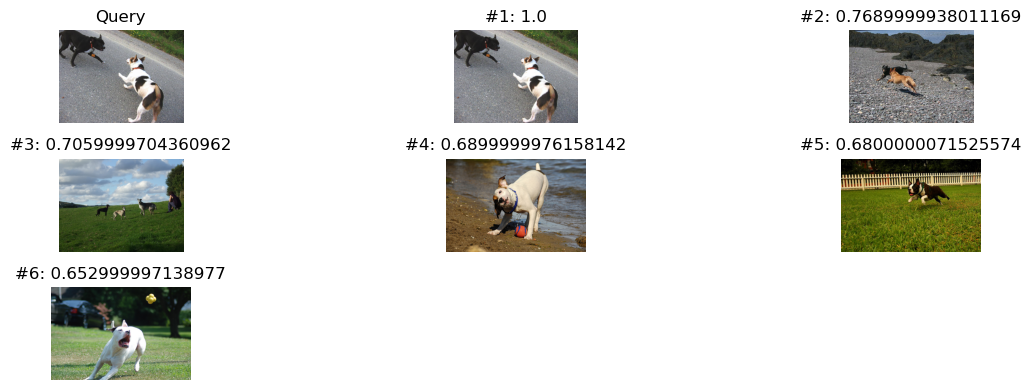

In [ ]:
# Simple caption display
def show_captions(stored_recommendations):
    print(f"Query: {stored_recommendations['query']['caption']}")
    print("\nRecommendations:")
    for rec in stored_recommendations['recommendations']:
        print(f"{rec['rank']}. {rec['caption']} (Score: {rec['similarity_score_rounded']})")

# Simple image display
import matplotlib.pyplot as plt
from PIL import Image

def show_images(stored_recommendations):
    recommendations = stored_recommendations['recommendations']
    query_info = stored_recommendations['query']
    
    total = len(recommendations) + 1
    cols = min(3, total)
    rows = (total + cols - 1) // cols
    
    plt.figure(figsize=(12, 4))
    
    # Show query image
    plt.subplot(rows, cols, 1)
    plt.imshow(Image.open(query_info['image_path']))
    plt.title("Query")
    plt.axis('off')
    
    # Show recommendations
    for i, rec in enumerate(recommendations, 2):
        plt.subplot(rows, cols, i)
        plt.imshow(Image.open(rec['image_path']))
        plt.title(f"#{rec['rank']}: {rec['similarity_score_rounded']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Combined function
def show_results(stored_recommendations):
    show_captions(stored_recommendations)
    show_images(stored_recommendations)

# Now this will work correctly
show_results(stored_recommendations)
